In [1]:
import torch.nn as nn
from commons import TRAIN_PATH, PUBLIC_TEST_PATH, PRIVATE_TEST_PATH
from commons import read_dataset, load_images, sample_batch, get_batch, train_model
from torchvision.models import resnet18
import numpy as np
from sklearn.model_selection import train_test_split
import torch

In [2]:
X, _, y = read_dataset(TRAIN_PATH + '/ER', 0, [], [], [])
X, _, y = read_dataset(TRAIN_PATH + '/NR', 1, X, _, y)
X, y = np.array(X), np.array(y)
# X[::1000], y[::1000]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)
len(X_test)

1341

In [2]:
assert torch.cuda.is_available()
device = 'cuda:0'

model = resnet18(pretrained=True)
model.fc = nn.Sequential(
    # nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=512, out_features=256, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=128, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=1, bias=True),
)
model = model.to(device)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [9]:
# it is possible change lr this way and the fine-tune model again
# for g in optimizer.param_groups:
#     g['lr'] = 1e-5

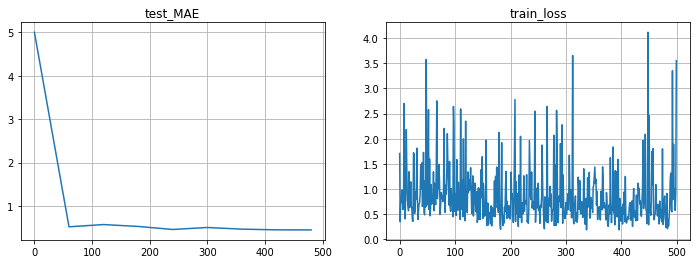

Mean loss=1.400
Last MAE*1000=452.561


In [10]:
train_model(model, optimizer, criterion, X_train, X_test, y_train, y_test, 60,
            16, 1000, 'MAE', device, 5, 'checkpoints/resnet_regression')

In [5]:
# model.load_state_dict(torch.load("checkpoints/resnet_regression_MAE_0.45256060988577684"))

<All keys matched successfully>

# Get predictions

In [7]:
preds_private = get_predictions(model, PRIVATE_TEST_PATH, 32, device)
preds_public = get_predictions(model, PUBLIC_TEST_PATH, 32, device)
preds = preds_private + preds_public

In [10]:
np.save('results/resnet_regression_preds_MAE_0.45256060988577684', preds)